In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from os import listdir

In [23]:
def update_progress(progress):
    ''' A simple function updating the time progress. 
    Inspired by 
    http://stackoverflow.com/questions/3173320/text-progress-bar-in-the-console 
    Parameters
    -----------
    progress : a value (float or int) between 0 and 100 indicating 
               percentage progress 
    Returns
    ----------
    None
    '''
    print '\r[%-10s] %0.2f%%' % ('#' * int(progress/10), progress),

## Initial sample of CRTS stars from Branimir ... 

First, find out the total number of objects to start with .. stars_CRTS/0/

In [3]:
pwd

u'/astro/users/suberlak/Desktop/SDSS'

In [206]:
dir1 = 'stars_CRTS/0/'

# make sure that we only take   stellar lightcurves,  which always end with .dat 
# and ignore two other files which may be there  : 
# radec.00   and file.list

stars_list  = []
for f in listdir(dir1) : 
    if f.endswith('.dat'):
        stars_list.append(f)
        
        


In [207]:
print('We have %d stars to start with ' % len(stars_list))

We have 52131 stars to start with 


## Remove empty files and those with less than 10 points 

In [209]:
c = 0 
empty_files = np.zeros(len(stars_list), dtype='bool')
for i in range(len(stars_list)):
    obj = stars_list[i]
    address = dir1 + obj
    f = open(address, 'r')
    if f.readline() == '' :
        c += 1
        empty_files[i] = True 
        
print('We have %d empty files' % c)   

We have 1410 empty files


In [210]:
stars_nonempty = np.array(stars_list)[~empty_files]
len(stars_nonempty)

50721

Remove those files that have less than 10 points : 

In [211]:
c = 0 
short_files  = np.zeros(len(stars_nonempty), dtype='bool')
for i in range(len(stars_nonempty)):
    obj = stars_nonempty[i]
    num_lines = sum(1 for line in open(dir1+obj))
    if num_lines < 10 :
        c += 1
        short_files[i] = True
        
print('We have %d  files with less than 10 pts ' % c) 

We have 1336  files with less than 10 pts 


In [212]:
stars_10_pts_plus = stars_nonempty[~short_files]
len(stars_10_pts_plus)

49385

## Day-averaged lightcurves : remove those with less than 10 days 

 ### : needs be RUN ONLY ONCE  to make them!

Make day-averaged lightcurves, save only if more than 10 observing days (points in the day-averaged light curve). 
Save MJD, avg_mag, error, N_obs that day.

In [35]:
# code based on the stars_crts_preprocessing.py 
# and QSO_CRTS_day_averaged_stats.py

dir_in = 'stars_CRTS/0/'
dir_err_w = 'stars_CRTS_LC_err_w/'

lc_files  = stars_10_pts_plus


k = 0
total = float(len(lc_files))

for obj in lc_files:
    percent = 100*(k / total)
    if (k % 10) == 0 : # every tenth loop.. 
        update_progress(int(percent))
    k += 1
    
    address=dir_in+obj
    data=np.loadtxt(address)
    
    averages=np.zeros(shape=(len(data),3))

    mjd = data[:,0]
    mags = data[:,1]
    errs = data[:,2]
   
    days = np.unique([int(day) for day in data[:,0]])
    
    # storage arrays  for each qso (all N's)
    mjd_arr = np.zeros_like(days).astype(float)
    avg_mags = np.zeros_like(days).astype(float)
    avg_err_weights = np.zeros_like(days).astype(float)  
    Nobs = np.zeros_like(days).astype(float)

    # loop through days calculating mean, etc. 
    for i in range(len(days)):
        day = days[i]
        int_mjd = np.require(mjd,int)       # forcing mjd array -> integers
        condition = (int_mjd == day)        # finding where int(mjd) = day
        N = float(len(mags[condition]))            # number of obs in that night 
        Nobs[i] = N
        avgmag = np.average(mags[condition],weights=errs[condition]) # works for single measurement too ! 
        
        # weights error : only that was used in the end 
        weights=1.0 / ( errs[condition] * errs[condition]) 
        avg_mags[i] = avgmag
        error_weights = 1.0 / np.sqrt(np.sum(weights))
        
        # increase error if too small 
        if error_weights < 0.02 : 
            error_weights = np.sqrt(error_weights**2.0 + 0.01**2.0)  
            
        avg_err_weights[i] = error_weights
      
        mjd_arr[i] = np.mean(mjd[condition])
        
    # Save the output... 
    # Once per lightcurve 
    # ONLY IF THERE IS MORE THAN 10 OBS ! 
    
    if( len(mjd_arr) >  10 ) :
        name_out = dir_err_w + 'out_'+obj[:18]+'.txt'
        np.savetxt(name_out, np.column_stack((mjd_arr,avg_mags, avg_err_weights, Nobs)),fmt='%11.4f')

        
    

[######### ] 99.00%


How many stars with LC  longer than 10 days we have  ? 

In [36]:
stars_LC_proc_err_w = listdir(dir_err_w)

In [37]:
len(stars_LC_proc_err_w)

48251

Calculate the stats of that sample : 
    
    

In [263]:
def compare_star_LC(i=None, n=None):
    '''A short function to plot an original stellar LC from CRTS (before all averaging, etc)
    to the day-averaged LC.
    
    Parameters: 
    -----------
    i = a number of the stellar processed LC in the stars_CRTS_LC_err_w/  dir 
     or  
    n = name of an original stellar LC , eg . '127648.dat' 
    Returns:
    --------
    None
    '''
    
    dir_in = 'stars_CRTS/0/'
    dir_err_w = 'stars_CRTS_LC_err_w/'
    stars_LC_10_days_plus= listdir(dir_err_w)
    if n ==None : 
        star_name_proc = stars_LC_10_days_plus[i]
    else :
        star_name_proc = 'out_'+ n +'.txt'
   
    orig_star_name = star_name_proc[4:-4]


    data = np.loadtxt(dir_err_w  + star_name_proc)
    data_orig = np.loadtxt(dir_in + orig_star_name)
    
    mjd_arr,avg_mags, avg_err_weights, Nobs = data[:,0], data[:,1], data[:,2], data[:,3]
    mjd,mags, errs = data_orig[:,0],data_orig[:,1], data_orig[:,2]
 

    %matplotlib inline

    fig, axs = plt.subplots(2,2, figsize=(16,10))
    ax = np.ravel(axs)
    ax[0].set_title('Original LC for '+orig_star_name)
    ax[0].scatter(mjd,mags)
    ax[0].errorbar(mjd, mags, errs, linestyle='None')
    print 'Vertical dashed lines indicate individual obs days '

    for day in days : 

        ax[0].axvline(day, ymin=0, ymax=0.2, lw =1, ls = '--', color='red')


    ax[1].set_title('Day-averaged LC for '+ orig_star_name)
    ax[1].scatter(mjd_arr,avg_mags, color='green')
    ax[1].errorbar(mjd_arr, avg_mags, avg_err_weights, linestyle='None', color='green')
    
    ax[2].set_title('Original and avg  LC for '+orig_star_name)
    ax[2].scatter(mjd,mags, alpha=0.5)
    ax[2].errorbar(mjd, mags, errs, linestyle='None',alpha=0.5)
    ax[2].scatter(mjd_arr,avg_mags,alpha=0.5, color='red')
    ax[2].errorbar(mjd_arr, avg_mags, avg_err_weights, linestyle='None', color='red')
    ax[3].axis('off')
    plt.show()

Vertical dashed lines indicate individual obs days 


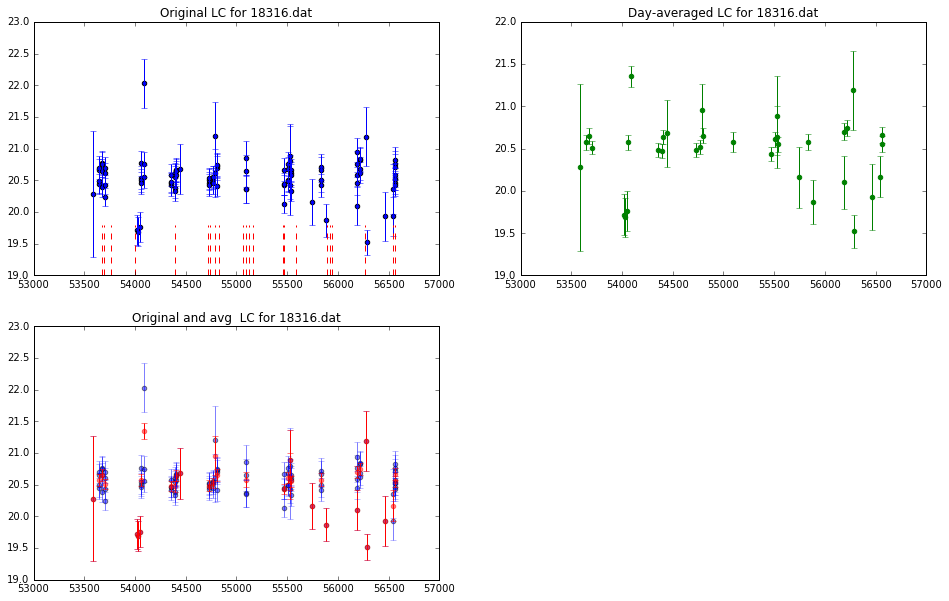

In [264]:
compare_star_LC(2)

Looks like the day-averaging is working fine.  Now , calculate the statistics for the day-averaged stars (takes about 3 mins on the workstation)

In [217]:
from collections import OrderedDict
dir_in = 'stars_CRTS/0/'
dir_err_w = 'stars_CRTS_LC_err_w/'

stars_LC_10_days_plus = []
for file in listdir(dir_err_w) : 
    if file.endswith('.txt'):
        stars_LC_10_days_plus.append(file)

remove_err_outliers = np.zeros_like(stars_LC_10_days_plus, dtype=bool)
stats_proc_err_w = OrderedDict()
keys = ['avg_mag', 'med_mag', 'avg_err', 'med_err', 'name', 'avg_err_90th_percentile']
for key in keys: 
    stats_proc_err_w[key] = [] 


k = 0
total = float(len(lc_files))

for i in range(len(stars_LC_10_days_plus)):
    percent = 100*(k / total)
    if (k % 10) == 0 : # every tenth loop.. 
        update_progress(int(percent))
    k += 1
    
    star_name_proc = stars_LC_10_days_plus[i]
    orig_star_name = star_name_proc[4:-4]


    data = np.loadtxt(dir_err_w  + star_name_proc)
    #data_orig = np.loadtxt(dir_in + orig_star_name)

    mjd_arr,avg_mags, avg_err_weights, Nobs = data[:,0], data[:,1], data[:,2], data[:,3]
    #mjd,mags, errs = data_orig[:,0],data_orig[:,1], data_orig[:,2]

    # Calculate stats for day-averaged stars 
    stats_proc_err_w['avg_mag'].append(np.mean(avg_mags))
    stats_proc_err_w['med_mag'].append(np.median(avg_mags))
    stats_proc_err_w['avg_err'].append(np.mean(avg_err_weights))
    stats_proc_err_w['med_err'].append(np.median(avg_err_weights))
    stats_proc_err_w['name'].append(orig_star_name)
    stats_proc_err_w['avg_err_90th_percentile'].append(np.percentile(avg_err_weights , 90))
    
    if (np.median(avg_err_weights) < 0.1 and np.percentile(avg_err_weights , 90)) < 0.2 : 
        remove_err_outliers[i] = True 

[######### ] 97.00%


Now, the list of those stars that pass through the error-outliers-removal  filter ought be the same as the list in  stars_CRTS_analysis/good_err_LC.txt , as well as filelist in stars_CRTS_proc_err_w_good/  . If it isn't, I can't claim I understand every single step... 

In [265]:
len(stars_LC_10_days_plus)

48250

In [218]:
acc_list = np.array(stars_LC_10_days_plus)[remove_err_outliers]
len(acc_list)

47797

In [267]:
dir1_list = listdir('stars_CRTS_LC_err_w/')
len(dir1_list)

48250

In [268]:
np.sum(np.in1d(stars_LC_10_days_plus, dir1_list))

48250

In [219]:
dir_list = listdir('stars_CRTS_proc_err_w_good/') 
len(dir_list)

47787

Which stars in the  'stars_CRTS_LC_err_w/' dir are not in  the stars_CRTS_proc_err_w_good/' dir ? 

In [273]:
missing_stars = np.array(dir1_list)[~np.in1d(dir1_list, dir_list)]
len(np.array(dir1_list)[~np.in1d(dir1_list, dir_list)])
np.savetxt('missing_stars_err_w_good_vs_err_w.txt', missing_stars, fmt='%s')

In [274]:
np.loadtxt('missing_stars_err_w_good_vs_err_w.txt', dtype=str)

array(['out_387854.dat.txt', 'out_331195.dat.txt', 'out_43434.dat.txt',
       'out_69406.dat.txt', 'out_20276.dat.txt', 'out_346300.dat.txt',
       'out_17875.dat.txt', 'out_970353.dat.txt', 'out_986515.dat.txt',
       'out_387982.dat.txt', 'out_993696.dat.txt', 'out_328559.dat.txt',
       'out_399315.dat.txt', 'out_999717.dat.txt', 'out_11814.dat.txt',
       'out_19012.dat.txt', 'out_986373.dat.txt', 'out_995049.dat.txt',
       'out_368402.dat.txt', 'out_998560.dat.txt', 'out_987405.dat.txt',
       'out_361430.dat.txt', 'out_999083.dat.txt', 'out_979183.dat.txt',
       'out_29890.dat.txt', 'out_997353.dat.txt', 'out_982951.dat.txt',
       'out_394312.dat.txt', 'out_387588.dat.txt', 'out_964115.dat.txt',
       'out_999561.dat.txt', 'out_974524.dat.txt', 'out_340656.dat.txt',
       'out_998839.dat.txt', 'out_373888.dat.txt', 'out_383407.dat.txt',
       'out_14390.dat.txt', 'out_992379.dat.txt', 'out_383016.dat.txt',
       'out_997875.dat.txt', 'out_16237.dat.txt', 'out_1299

In [220]:
file_list = np.loadtxt('stars_CRTS_analysis/good_err_LC.txt', dtype=str)
len(file_list)

47787

In [221]:
np.sum(np.in1d(dir_list,file_list))

47787

The above means that the lightcurves  in 'stars_CRTS_proc_err_w_good/'  are exactly those listed in 'stars_CRTS_analysis/good_err_LC.txt'  produced by qso_CRTS_good_LC_choosing_err_based.py
 

In [222]:
np.sum(np.in1d(acc_list, dir_list))

47787

In [223]:
np.sum(np.in1d(dir_list,stars_LC_10_days_plus))

47787

So all the LCs in the  'stars_CRTS_proc_err_w_good/' are accepted by the miswritten filter,  but there are 11 lightcurves that were not accepted by that filter before , and were now. 


Since it turns out that the entire filter was miswritten ( the qso_CRTS_good_LC_choosing_err_based.py has an error in brackets in line  34 which is the condition of the filter ) , it definitely did not work as expected.  

Thus , I need to compare the properties of lightcurves  in  'stars_CRTS_LC_err_w/' (the day-averaged with only those longer than and including 10 days)  to those in   'stars_CRTS_proc_err_w_good/'   (the outcome of the erroneous filtration :  
` (np.median(err) < 0.1 and np.percentile(err,90)) < 0.2  `

http://jupyter.cs.brynmawr.edu/hub/dblank/public/Jupyter%20Notebook%20Users%20Manual.ipynb#4.-Using-Markdown-Cells-for-Writing

Calculate the properties of  'stars_CRTS_proc_err_w_good/' : 

In [174]:
dir_err_w = 'stars_CRTS_proc_err_w_good/'
stars_LC= listdir(dir_err_w)

#remove_err_outliers = np.zeros_like(stars_LC, dtype=bool)

stats_proc_err_wg = OrderedDict()
keys = ['avg_mag', 'med_mag', 'avg_err', 'med_err', 'name', 'avg_err_90th_percentile']
for key in keys: 
    stats_proc_err_wg[key] = [] 

k = 0
total = float(len(lc_files))

for i in range(len(stars_LC)):
    # update progress...
    percent = 100*(k / total)
    if (k % 10) == 0 : # every tenth loop.. 
        update_progress(int(percent))
    k += 1
    
    star_name_proc = stars_LC[i]
    data = np.loadtxt(dir_err_w  + star_name_proc)
    mjd_arr,avg_mags, avg_err_weights = data[:,0], data[:,1], data[:,2]

    # Calculate stats for day-averaged stars 
    stats_proc_err_wg['avg_mag'].append(np.mean(avg_mags))
    stats_proc_err_wg['med_mag'].append(np.median(avg_mags))
    stats_proc_err_wg['avg_err'].append(np.mean(avg_err_weights))
    stats_proc_err_wg['med_err'].append(np.median(avg_err_weights))
    stats_proc_err_wg['name'].append(star_name_proc[4:-4])
    stats_proc_err_wg['avg_err_90th_percentile'].append(np.percentile(avg_err_weights , 90))


[######### ] 96.00%


In [225]:
np.median(stats_proc_err_wg['avg_err'])

0.089423456790123465

In [226]:
np.median(stats_proc_err_w['avg_err'])

0.091374368686868684

(0.0, 1.0, 0.0, 1.0)

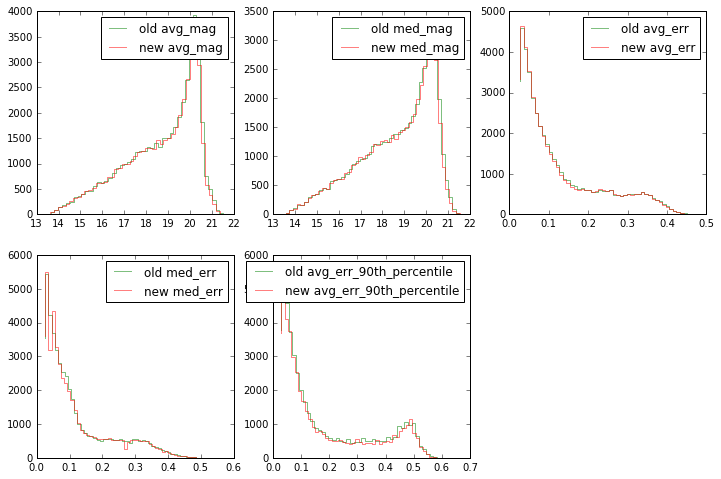

In [262]:
# Plot histograms comparing the two dirs  (original - unfiltered    and the incorrectly-filtered ) ... 
%matplotlib inline 
nbins = 50

fig, axs = plt.subplots(2,3, figsize=(12,8))
ax = np.ravel(axs)
keys = stats_proc_err_w.keys()
keys.remove('name')

i = 0 
for key  in keys:
    hist1, bin_edges = np.histogram(stats_proc_err_w[key], bins = nbins, density=False)
    bin_cen1 = (bin_edges[:-1] + bin_edges[1:])/2

    hist2, bin_edges = np.histogram(stats_proc_err_wg[key], bins = nbins, density=False)
    bin_cen2 = (bin_edges[:-1] + bin_edges[1:])/2

    ax[i].plot(bin_cen1, hist1, color = 'green', alpha=0.5, ls='steps', label='old '+ key)
    ax[i].plot(bin_cen2, hist2, color = 'red', alpha=0.5, ls='steps', label='new '+ key)
    ax[i].legend(loc='upper right')
    i += 1 
ax[i].axis('off')

They are pretty much the same, so no reason to worry.  If Z. thinks it better to use the error-outliers clipping,  I can always select only those that are actually fulfulling the crieria, and remove them from the stars_CRTS_proc_err_w_good/ directory, and just rerun  the code for Fig.2, Fig.3 and Fig. 4  . 

Below  `old` means  stars_CRTS_processed_err_w/  which is the same as the newly-made   stars_CRTS_LC_err_w/  (before applying 'remove error outliers' filter ), 
and `new` means stars_CRTS_proc_err_w_good/  (after applying an erroneous filter, which God knows what it did )  . 

In [229]:
for key in keys : 
    print('The mean of %s : unfiltered vs  filtered : %f vs  %f '%(key, np.mean(stats_proc_err_w[key]),
                                                               np.mean(stats_proc_err_wg[key]) ) )

The mean of avg_mag : unfiltered vs  filtered : 18.735371 vs  18.688128 
The mean of med_mag : unfiltered vs  filtered : 18.741062 vs  18.693179 
The mean of avg_err : unfiltered vs  filtered : 0.133401 vs  0.132130 
The mean of med_err : unfiltered vs  filtered : 0.124622 vs  0.123837 
The mean of avg_err_90th_percentile : unfiltered vs  filtered : 0.186803 vs  0.184350 


In [230]:
for key in keys : 
    print('The median of %s : unfiltered vs  filtered : %f vs  %f '%(key, np.median(stats_proc_err_w[key]),
                                                               np.median(stats_proc_err_wg[key]) ) )

The median of avg_mag : unfiltered vs  filtered : 19.173552 vs  19.095185 
The median of med_mag : unfiltered vs  filtered : 19.160000 vs  19.084700 
The median of avg_err : unfiltered vs  filtered : 0.091374 vs  0.089423 
The median of med_err : unfiltered vs  filtered : 0.084500 vs  0.083500 
The median of avg_err_90th_percentile : unfiltered vs  filtered : 0.109295 vs  0.106750 


If I were to apply the actual filter in a correct way , here is the comparison  : 
    
    

In [258]:
# require  the median error to be  < 0.1,   and the 90th percentile of the error distribution to be < 0.2 
mask = (np.array(stats_proc_err_w['med_err']) < 0.1) * (np.array(stats_proc_err_w['avg_err_90th_percentile']) < 0.2) 


In [255]:
len('avg_err_90th_pe')

15

In [254]:
np.sum(mask)

27536

(0.0, 1.0, 0.0, 1.0)

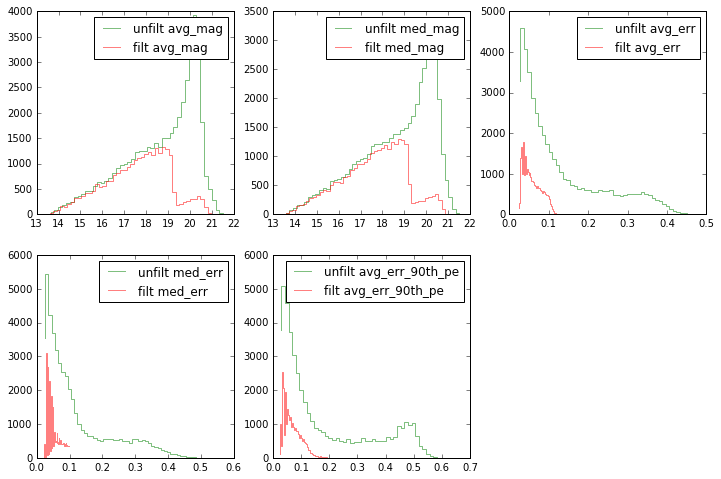

In [261]:
# Plot histograms comparing the original (unfiltered)  vs filtered (correctly )
%matplotlib inline 
nbins = 50

fig, axs = plt.subplots(2,3, figsize=(12,8))
ax = np.ravel(axs)
keys = stats_proc_err_w.keys()
keys.remove('name')

i = 0 
for key  in keys:
    hist1, bin_edges = np.histogram(stats_proc_err_w[key], bins = nbins, density=False)
    bin_cen1 = (bin_edges[:-1] + bin_edges[1:])/2

    hist2, bin_edges = np.histogram(np.array(stats_proc_err_w[key])[mask], bins = nbins, density=False)
    bin_cen2 = (bin_edges[:-1] + bin_edges[1:])/2

    ax[i].plot(bin_cen1, hist1, color = 'green', alpha=0.5, ls='steps', label='unfilt '+ key[:15])
    ax[i].plot(bin_cen2, hist2, color = 'red', alpha=0.5, ls='steps', label='filt '+ key[:15])
    ax[i].legend(loc='upper right')
    i += 1 
# http://stackoverflow.com/questions/10035446/how-can-i-make-a-blank-subplot-in-matplotlib 
ax[i].axis('off')

I think it's better not to apply that filter  - otherwise our selection later (based precisely on average CRTS  lightcurve error) would not make any sense.  

I think I would make an executive decision of NOT applying any filter at this stage, but instead in all analysis for Fig.2, Fig.3, Fig.4  use  stars_CRTS_processed_err_w/  or  stars_CRTS_LC_err_w/ , since these two directories contain identical lightcurves, which have gone through exactly as many selection steps as quasars did.  